In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from math import log2, floor, ceil
from statistics import mean, median

In [8]:
def load_file(filename):
    a = np.loadtxt(filename, dtype='str', comments='#')
    rsp = [round(float(x),6) for x in  a[:,0]]
    latencies = a[:,1]
    times = a[:,2]
    processors = a[:,3]
    work = a[:,4]
    i_steals = a[:,16]
    e_steals = a[:,17]
    return rsp, latencies, times, processors, work, i_steals, i_steals

directory = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_50p/"
directory_70p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_70p/"
directory_80p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_80p/"
directory_90p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_90p/"



In [9]:
def compute_average(values, latence):
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            run_number[float(rsp[i])] += 1
            average[float(rsp[i])] += int(values[i])
            
    for cle in average:
        average[cle] /= run_number[cle]
    return average

def compute_overhead_for_latence(data, latence):
    rsp, latencies, times, processors, work = data
    all_average = defaultdict(list)
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            #run_number[float(rsp[i])] += 1
            all_average[float(rsp[i])].append(float(int(times[i]) - int(work[i])/int(processors[i])))
    for cle in sorted(all_average):
        size = len(all_average[cle])
        #average[cle] = mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)])
        average[cle] = mean(all_average[cle])
        #print(mean(all_average[cle]), mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)]))
  #      average[cle] = median(all_average[cle])

    return all_average, average, min(average.keys(), key=lambda x : average[x])


def compute_overhead(data, latence, variable):
    rsp, latencies, times, processors, work = data
    average = defaultdict(int)
    run_number = defaultdict(int)
    average = 0
    run_number = 0
    
    for i in range(len(rsp)):
        if float(rsp[i]) == variable and float(latencies[i]) == latence:
            run_number += 1
            average += float(int(times[i]) - int(work[i])/int(processors[i]))
            
    return average/run_number

In [10]:
def plot_for_best(filename):
    best = dict()
    base_line = dict()
    data = load_file(filename)
    latencies = data[1]
    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, avg_overhead, minimum  = compute_overhead_for_latence(data, int(latence))
        best_avg_overhead = compute_overhead(data, int(latence), minimum)
        best[latence] = best_avg_overhead
        if minimum < 1:
            base_line[latence] = compute_overhead(data, int(latence), 0.5)
            #print(latence, minimum)
    
    return best, base_line

In [11]:
def latence_for_best_param(filename):
    data = load_file(filename)
    latencies = data[1]
    best = dict()

    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, overhead, minimum = compute_overhead_for_latence(data, int(latence))
        #plt.subplot(223)
        plt.plot(overhead.keys(), overhead.values())
        best[latence] = minimum
    return best

In [12]:
def best_overhead_dict(directory):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32):
            filename = directory + "vss_proba_" + str(p) + "_" + str(w)
            best, _ = plot_for_best(filename)
            for latence in best.keys():
                best_value_w[(p, int(latence))][w]=best[latence]
                best_value_p[(w, int(latence))][p]=best[latence]
                best_value_l[(w, p)][int(latence)]=best[latence]

    return best_value_w, best_value_p, best_value_l

# A faire  :

Tourner des résultats pour rsp entre 0.001 et 0.02 pour bien tracer les courbes

Afficher l'interval de confiance


In [13]:
def best_value_dict(directory, seuil):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32,64):
            filename = directory + "vss_proba_" + str(p) + "_" + str(w)
            data = load_file(filename)
            for latence in (128,256,512,1024):
                _, overhead, minimum = compute_overhead_for_latence(data, latence)
                
                overhead_min = overhead[minimum]
                interval_max = overhead[minimum]  + 2*latence/p #+ overhead[minimum]*seuil/100

                #print(minimum, overhead[minimum], interval_max)
                
                
                overhead_plage = list(filter(lambda x : overhead_min <= overhead[x] <= interval_max, overhead))
                
                #print([(x, overhead[x]) for x in overhead_plage])
                
                best_value_w[(p, int(latence))][w]= overhead_plage
                best_value_p[(w, int(latence))][p]= overhead_plage
                best_value_l[(w, p)][int(latence)]= overhead_plage

    return best_value_w, best_value_p, best_value_l



## overhead en fonction proba 

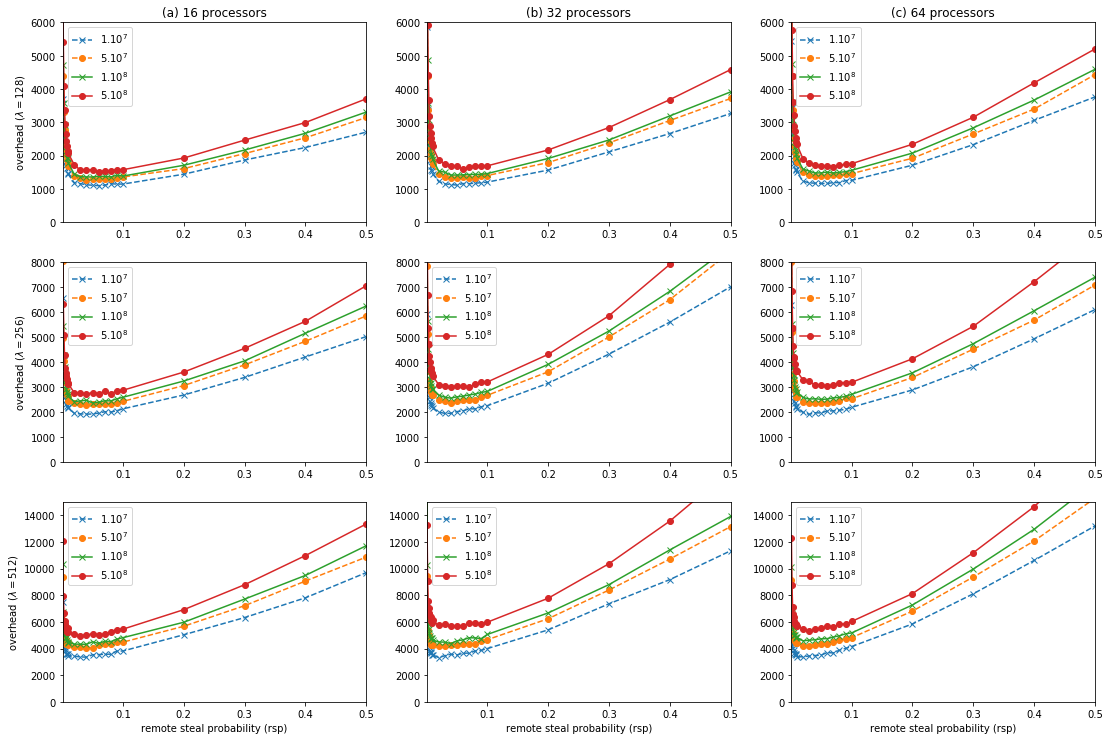

In [17]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

plt.subplot(331)
plt.xlim(0.001, 0.5)
#plt.xlabel("remote steal probability")
plt.ylabel("overhead ($\lambda = 128$)")
plt.title("(a) 16 processors")

plt.ylim(0, 6000)

data = load_file(directory + "vss_proba_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")
plt.legend()


plt.subplot(332)
plt.xlim(0.001, 0.5)
plt.ylim(0, 6000)
plt.title("(b) 32 processors")

data = load_file(directory + "vss_proba_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


plt.subplot(333)
plt.xlim(0.001, 0.5)
plt.ylim(0, 6000)
plt.title("(c) 64 processors")

data = load_file(directory + "vss_proba_64_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_64_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_64_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_64_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


plt.legend()

#------- 128

plt.subplot(334)
plt.xlim(0.001, 0.5)
plt.ylabel("overhead ($\lambda = 256$)")

plt.ylim(0, 8000)

data = load_file(directory + "vss_proba_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()
plt.subplot(335)
plt.xlim(0.001, 0.5)
plt.ylim(0, 8000)

data = load_file(directory + "vss_proba_64_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")
data = load_file(directory + "vss_proba_64_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_64_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_64_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


plt.legend()
plt.subplot(336)
plt.xlim(0.001, 0.5)
plt.ylim(0, 8000)

data = load_file(directory + "vss_proba_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")
data = load_file(directory + "vss_proba_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()


#------- 256
plt.subplot(337)
plt.xlim(0.001, 0.5)
plt.xlabel("remote steal probability (rsp)")
plt.ylabel("overhead ($\lambda = 512$)")

plt.ylim(0, 15000)

data = load_file(directory + "vss_proba_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()
plt.subplot(338)
plt.xlim(0.001, 0.5)
plt.ylim(0, 15000)
plt.xlabel("remote steal probability (rsp)")

data = load_file(directory + "vss_proba_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


plt.legend()
plt.subplot(339)
plt.xlim(0.001, 0.5)
plt.ylim(0, 15000)
plt.xlabel("remote steal probability (rsp)")

data = load_file(directory + "vss_proba_64_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_proba_64_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_proba_64_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_proba_64_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")
plt.legend()

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_rsp_l.pdf',bbox_inches='tight')

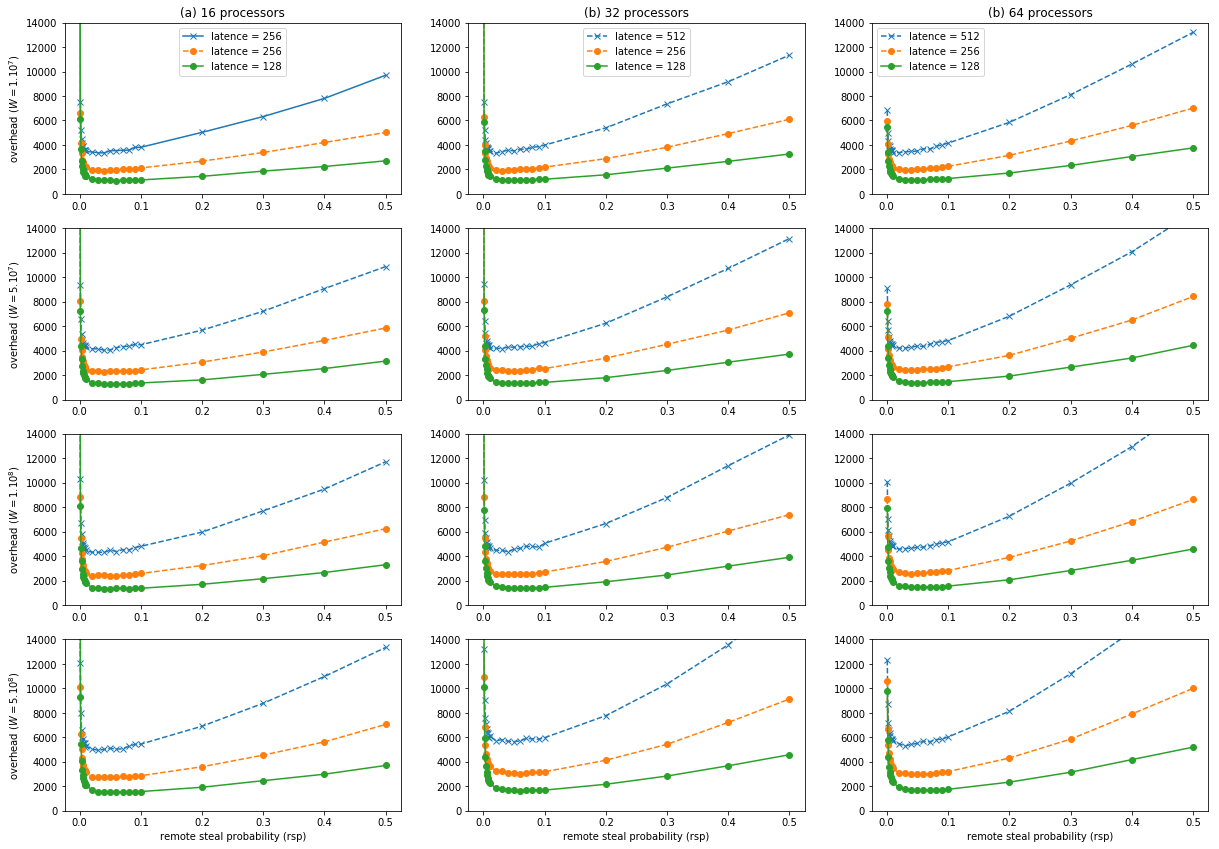

In [18]:
fig = plt.figure()
fig.set_size_inches(20.5, 14.5, forward=True)

data = load_file(directory + "vss_proba_16_10000000")
plt.subplot(4, 3, 1)
plt.ylim(0,14000)
plt.ylabel("overhead ($W = 1.10^7$)")

plt.title("(a) 16 processors")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x-", label="latence = 256")
plt.legend()
#print("min for vss_proba_16_10000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
plt.legend()
#print("min for vss_proba_16_10000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
plt.legend()
#print("min for vss_proba_16_10000000 : ", minimum)


plt.subplot(4, 3, 2)
plt.title("(b) 32 processors")
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_32_10000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)


_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)


plt.subplot(4, 3, 3)
plt.title("(b) 64 processors")
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_64_10000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)


_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
plt.legend()
#print("min for vss_proba_32_10000000 : ", minimum)


#---- ligne 2

data = load_file(directory + "vss_proba_16_50000000")
plt.subplot(4, 3, 4)
plt.ylim(0,14000)
plt.ylabel("overhead ($W = 5.10^7$)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_16_50000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_16_50000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_16_50000000 : ", minimum)


plt.subplot(4, 3, 5)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_32_50000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)

plt.subplot(4, 3, 6)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_64_50000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_50000000 : ", minimum)


#---- ligne 3

data = load_file(directory + "vss_proba_16_100000000")
plt.subplot(4, 3, 7)
plt.ylim(0,14000)
plt.ylabel("overhead ($W = 1.10^8$)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_16_100000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_16_100000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_16_100000000 : ", minimum)


plt.subplot(4, 3, 8)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_32_100000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

plt.subplot(4, 3, 9)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_64_100000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

#---- ligne 4

data = load_file(directory + "vss_proba_16_500000000")
plt.subplot(4, 3, 10)
plt.ylim(0,14000)
plt.ylabel("overhead ($W = 5.10^8$)")
plt.xlabel("remote steal probability (rsp)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_proba_16_500000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_16_500000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_16_500000000 : ", minimum)


plt.subplot(4,3,11)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_32_500000000")
plt.xlabel("remote steal probability (rsp)")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)


plt.subplot(4,3,12)
plt.ylim(0,14000)
data = load_file(directory + "vss_proba_64_500000000")
plt.xlabel("remote steal probability (rsp)")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="latence = 256")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="latence = 128")
#plt.legend()
#print("min for vss_proba_32_100000000 : ", minimum)

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_rsp_w.pdf',bbox_inches='tight')



#en fonction $W$


/home/khatiri/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


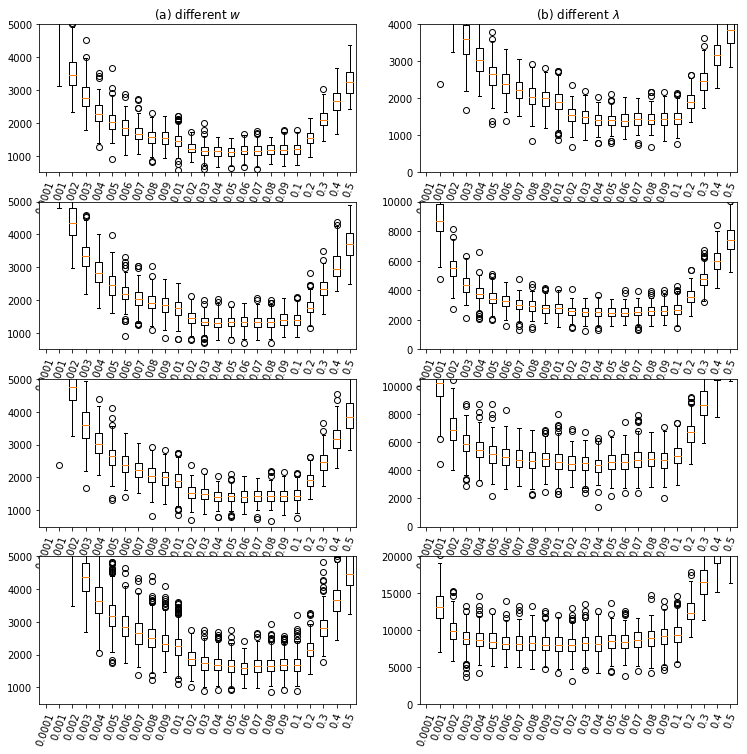

In [19]:
def boxdata(p, w, l, rspmin, rspmax):
    data = load_file(directory + "vss_proba_{}_{}".format(p,w))
    all_average, overhead, minimum = compute_overhead_for_latence(data, l)
    #print(all_average)
    return [all_average[x] for x in all_average.keys() if rspmin <= x and x <= rspmax], \
[round(x,6) for x in all_average.keys() if rspmin <= x and x <= rspmax]
    
fig = plt.figure()
fig.set_size_inches(12.5, 12.5, forward=True)

list_avrg, list_keys = boxdata(32, 10000000, 128, 0, 0.5)
plt.subplot(421)
plt.title("(a) different $w$")
plt.ylim(500, 5000)
plt.xticks(rotation=70)
plt.plot([0.006,0.007,0.008],[5000,5000,5000])
plt.boxplot(list_avrg, labels = list_keys) #showmeans=True, 

list_avrg, list_keys = boxdata(32, 50000000, 128, 0, 0.5)
plt.subplot(423)
plt.ylim(500, 5000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 

list_avrg, list_keys = boxdata(32, 100000000, 128, 0, 0.5)
plt.subplot(425)
plt.ylim(500, 5000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg,labels = list_keys) 

list_avrg, list_keys = boxdata(32, 500000000, 128, 0, 0.5)
plt.subplot(427)
plt.ylim(500, 5000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 

#----------------

list_avrg, list_keys = boxdata(32, 100000000, 128, 0, 0.5)
plt.subplot(422)
plt.title("(b) different $\lambda$")
plt.ylim(0, 4000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) #showmeans=True, 

list_avrg, list_keys = boxdata(32, 100000000, 256, 0, 0.5)
plt.subplot(424)
plt.ylim(0, 10000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 
plt.subplot(424)

list_avrg, list_keys = boxdata(32, 100000000, 512, 0, 0.5)
plt.subplot(426)
plt.ylim(0, 10500)
plt.xticks(rotation=70)
plt.boxplot(list_avrg,labels = list_keys) 

list_avrg, list_keys = boxdata(32, 100000000, 1024, 0, 0.5)
plt.subplot(428)
plt.ylim(0, 20000)
plt.xticks(rotation=70)
plt.boxplot(list_avrg, labels = list_keys) 


plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/zoom_overhead_according_rsp_w.pdf',bbox_inches='tight')


#plt.ylim(1800, 2250)
#plt.xlim(0.01, 0.07)
#plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


In [42]:
best_w, best_p, best_l = best_value_dict(directory, 2)


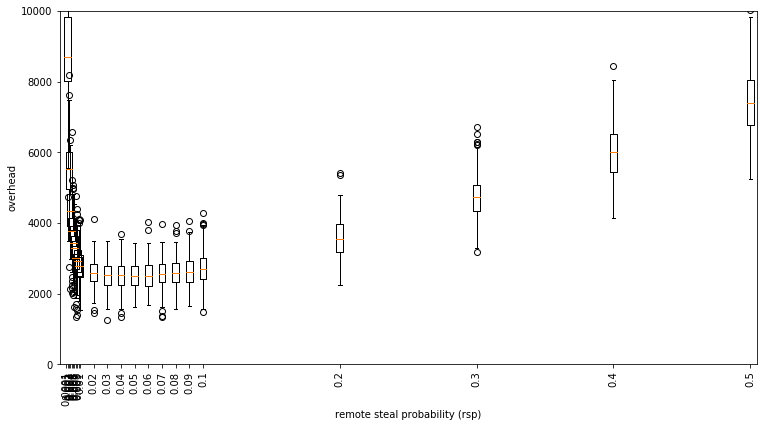

In [43]:
fig = plt.figure()
fig.set_size_inches(12.5, 6.5, forward=True)
list_avrg, list_keys = boxdata(32, 100000000, 256, 0, 0.5)
maxim = max(best_w[(32,1024)][100000000])
#plt.subplot(111)

plt.xlabel("remote steal probability (rsp)")
plt.ylabel("overhead")

plt.ylim(0, 10000)
plt.xticks(rotation=90)
w = [0.1]*len(list_keys)
keys_positions = [x*100 for x in list_keys]
plt.boxplot(list_avrg, positions=keys_positions, labels = list_keys) 
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot([x*100 for x in overhead.keys()], overhead.values(), "o--", label="latence = 256")

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/zoom_overhead_according_rsp_w100000000_32_256.pdf',bbox_inches='tight')


#en fonction $latence$


In [7]:
best_w, best_p, best_l = best_value_dict(directory, 2)

fig = plt.figure()
fig.set_size_inches(12.5, 10.5, forward=True)
plt.title("$\lambda$=124")
a = 221
for k in best_w.keys():
    if k[0] == 16 and k[1] in [1024]:
        for i in best_w[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_w[k][i], [i for _ in range(len(best_w[k][i]))], "o-", label="$w$="+str(i))
            #plt.legend()

a += 1
for k in best_w.keys():
    if k[0] == 32 and k[1] in [1024]:
        for i in best_w[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_w[k][i], [i for _ in range(len(best_w[k][i]))], "o-", label="$w$="+str(i))
            #plt.legend()          
a += 1
for k in best_w.keys():
    if k[0] == 64 and k[1] in [1024]:
        for i in best_w[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_w[k][i], [i for _ in range(len(best_w[k][i]))], "o-", label="$w$="+str(i))
            #plt.legend()          

            

NameError: name 'best_value_dict' is not defined

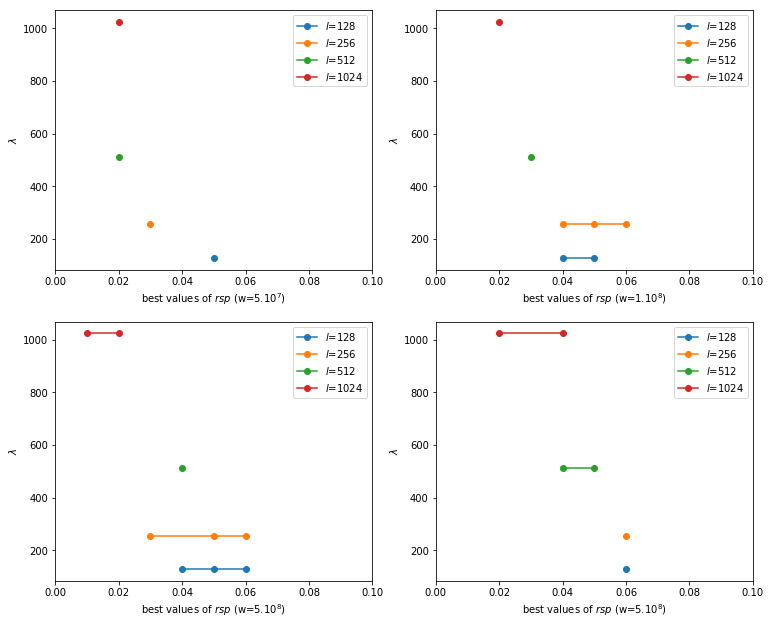

In [40]:
best_w, best_p, best_l = best_value_dict(directory, 100)
fig = plt.figure()
fig.set_size_inches(12.5, 10.5, forward=True)
a = 221
for k in best_l.keys():
    if k[0] == 10000000 and k[1] == 32:
        for i in best_l[k].keys():
            plt.ylabel("$\lambda$")
            plt.xlabel("best values of $rsp$ (w=$1.10^7$)")
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="$l$="+str(i))
            plt.legend()

a += 1
for k in best_l.keys():
    if k[0] == 50000000 and k[1] == 32:
        for i in best_l[k].keys():
            plt.ylabel("$\lambda$")
            plt.xlabel("best values of $rsp$ (w=$5.10^7$)")
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="$l$="+str(i))
            plt.legend()          
a += 1
for k in best_l.keys():
    if k[0] == 100000000 and k[1] == 32:
        for i in best_l[k].keys():
            plt.ylabel("$\lambda$")
            plt.xlabel("best values of $rsp$ (w=$1.10^8$)")
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="$l$="+str(i))
            plt.legend()          
a += 1
for k in best_l.keys():
    if k[0] == 500000000 and k[1] == 32:
        for i in best_l[k].keys():
            plt.ylabel("$\lambda$")
            plt.xlabel("best values of $rsp$ (w=$5.10^8$)")
            plt.subplot(a)
            plt.xlim(0, 0.1)
            #a += 2
            plt.plot( best_l[k][i], [i for _ in range(len(best_l[k][i]))], "o-", label="$l$="+str(i))
            plt.legend()          


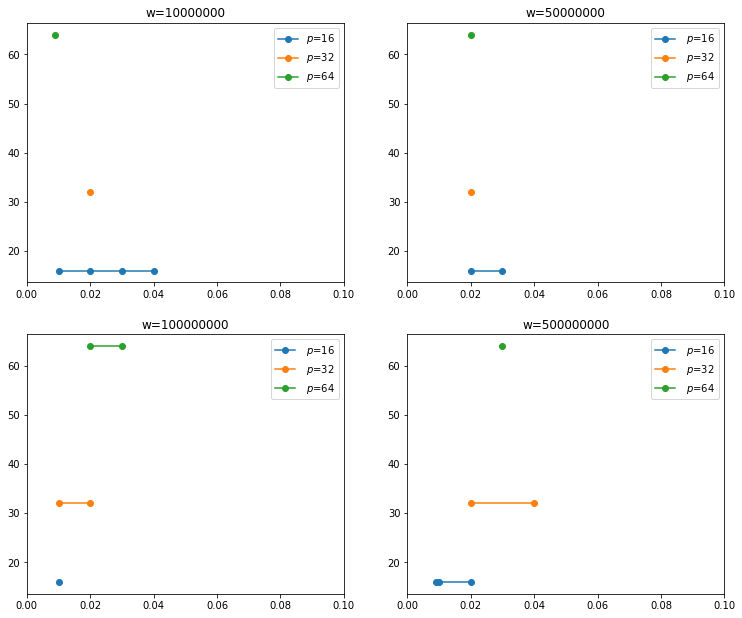

In [41]:
best_w, best_p, best_l = best_value_dict(directory, 5)
fig = plt.figure()
fig.set_size_inches(12.5, 10.5, forward=True)
plt.title("$\lambda$=124")
a = 221
for k in best_p.keys():
    if k[0] == 10000000 and k[1] == 1024:
        for i in best_p[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_p[k][i], [i for _ in range(len(best_p[k][i]))], "o-", label="$p$="+str(i))
            plt.legend()

a += 1
for k in best_p.keys():
    if k[0] == 50000000 and k[1] == 1024:
        for i in best_p[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_p[k][i], [i for _ in range(len(best_p[k][i]))], "o-", label=" $p$="+str(i))
            plt.legend()          
a += 1
for k in best_p.keys():
    if k[0] == 100000000 and k[1] == 1024:
        for i in best_p[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            plt.plot( best_p[k][i], [i for _ in range(len(best_p[k][i]))], "o-", label=" $p$="+str(i))
            plt.legend()          
a += 1
for k in best_p.keys():
    if k[0] == 500000000 and k[1] == 1024:
        for i in best_p[k].keys():
            plt.subplot(a)
            plt.xlim(0, 0.1)
            plt.title("w="+str(k[0]))
            #a += 2
            plt.plot( best_p[k][i], [i for _ in range(len(best_p[k][i]))], "o-", label=" $p$="+str(i))
            plt.legend()          

#en fonction $Proc\_number$


# A faire :

tourner des simulations entre avec max_internal_steal entre {0 40} pour savoir une courbe bien precis

Afficher l'interface de confiance

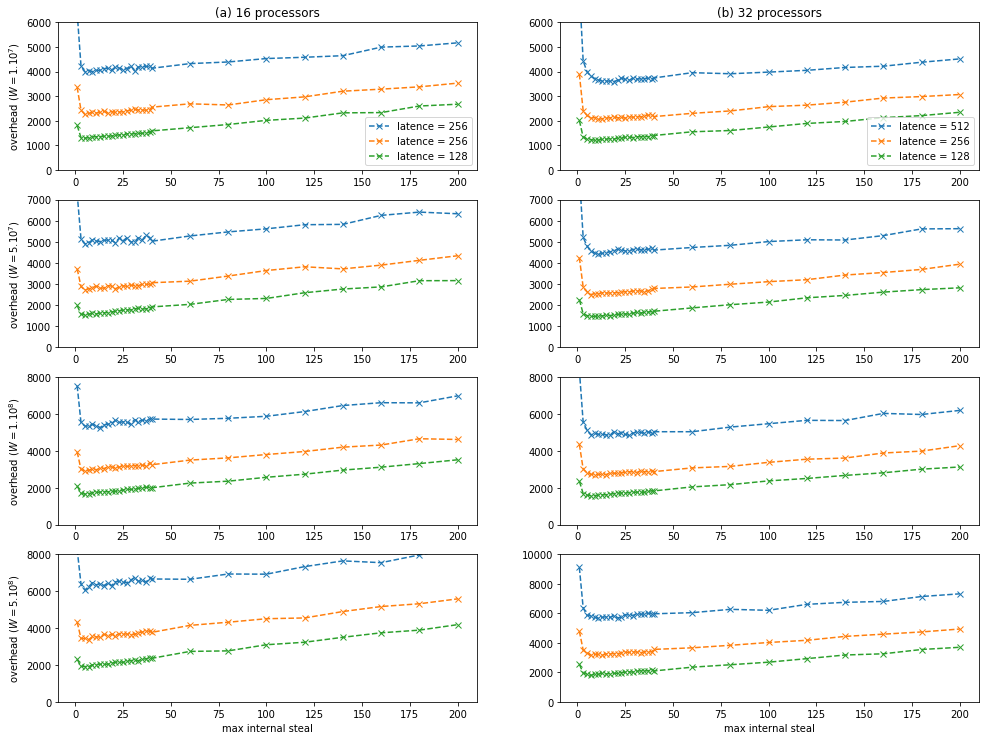

In [92]:
fig = plt.figure()
fig.set_size_inches(16.5, 12.5, forward=True)

directory = "/home/khatiri/these/projet/ws-simulator/src/resultat_finition/static/"

data = load_file(directory + "vss_static_16_10000000")
plt.subplot(421)
plt.ylim(0,6000)
plt.ylabel("overhead ($W = 1.10^7$)")

plt.title("(a) 16 processors")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_static_16_10000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_static_16_10000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
plt.legend()
#print("min for vss_static_16_10000000 : ", minimum)


plt.subplot(422)
plt.title("(b) 32 processors")
plt.ylim(0,6000)
data = load_file(directory + "vss_static_32_10000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
plt.legend()
#print("min for vss_static_32_10000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
plt.legend()
#print("min for vss_static_32_10000000 : ", minimum)


_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
plt.legend()
#print("min for vss_static_32_10000000 : ", minimum)


#---- ligne 2

data = load_file(directory + "vss_static_16_50000000")
plt.subplot(423)
plt.ylim(0,7000)
plt.ylabel("overhead ($W = 5.10^7$)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_16_50000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_16_50000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_16_50000000 : ", minimum)


plt.subplot(424)
plt.ylim(0,7000)
data = load_file(directory + "vss_static_32_50000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_32_50000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_32_50000000 : ", minimum)


#---- ligne 3

data = load_file(directory + "vss_static_16_100000000")
plt.subplot(425)
plt.ylim(0,8000)
plt.ylabel("overhead ($W = 1.10^8$)")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_16_100000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_16_100000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_16_100000000 : ", minimum)


plt.subplot(426)
plt.ylim(0,8000)
data = load_file(directory + "vss_static_32_100000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)


#---- ligne 4

data = load_file(directory + "vss_static_16_500000000")
plt.subplot(427)
plt.ylim(0,8000)
plt.ylabel("overhead ($W = 5.10^8$)")
plt.xlabel("max internal steal")

_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_16_500000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_16_500000000 : ", minimum)
_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_16_500000000 : ", minimum)


plt.subplot(428)
plt.ylim(0,10000)
plt.xlabel("max internal steal")
data = load_file(directory + "vss_static_32_500000000")
_, overhead, minimum = compute_overhead_for_latence(data, 512)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 512")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 256")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

_, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="latence = 128")
#plt.legend()
#print("min for vss_static_32_100000000 : ", minimum)

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_static_max_w.pdf',bbox_inches='tight')

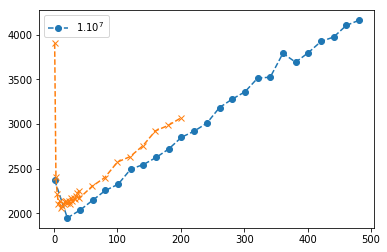

In [91]:

#data = load_file(directory + "vss_static_32_10000000")
#all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
#plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")


filename = "/home/khatiri/these/projet/ws-simulator/Simulation/"


data = load_file(filename + "vss_static_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="1.$10^7$")
plt.legend()


directory = "/home/khatiri/these/projet/ws-simulator/src/resultat_finition/static/"

data = load_file(directory + "vss_static_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")


In [ ]:
fig = plt.figure()
fig.set_size_inches(16.5, 12.5, forward=True)

plt.subplot(321)
#plt.xlabel("remote steal probability")
plt.ylabel("overhead ($\lambda = 64$)")
plt.title("(a) 16 processors")

plt.ylim(0, 5000)

data = load_file(directory + "vss_static_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")


plt.legend()

plt.legend()
plt.subplot(322)
plt.ylim(0, 5000)
plt.title("(b) 32 processors")

data = load_file(directory + "vss_static_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 64)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()

#------- 128

plt.subplot(323)
plt.ylabel("overhead ($\lambda = 128$)")

plt.ylim(0, 6000)

data = load_file(directory + "vss_static_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()
plt.subplot(324)
plt.ylim(0, 6000)

data = load_file(directory + "vss_static_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")
data = load_file(directory + "vss_static_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()


#------- 256
plt.subplot(325)
plt.xlabel("remote steal probability")
plt.ylabel("overhead ($\lambda = 256$)")

plt.ylim(0, 7000)

data = load_file(directory + "vss_static_16_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_16_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_16_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_16_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()
plt.subplot(326)
plt.ylim(0, 7000)

plt.xlabel("remote steal probability")

data = load_file(directory + "vss_static_32_10000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x--", label="1.$10^7$")

data = load_file(directory + "vss_static_32_50000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o--", label="5.$10^7$")

data = load_file(directory + "vss_static_32_100000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "x-", label="1.$10^8$")

data = load_file(directory + "vss_static_32_500000000")
all_average, overhead, minimum = compute_overhead_for_latence(data, 256)
plt.plot(overhead.keys(), overhead.values(), "o-", label="5.$10^8$")

plt.legend()

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/overhead_according_static_max_l.pdf',bbox_inches='tight')

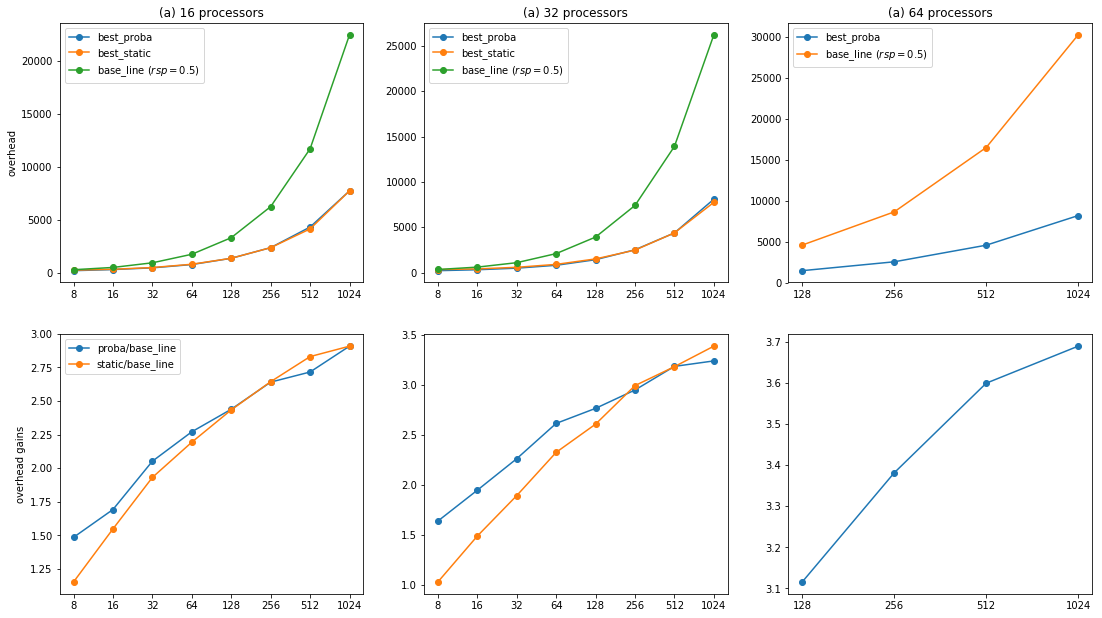

In [54]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"


filename = directory_s + "vss_static_16_100000000"
best_static, _ = plot_for_best(filename)

filename = directory_p + "vss_proba_16_100000000"
best_proba, base_line = plot_for_best(filename)

filename = directory_s + "vss_static_16_100000000"
best_static, _ = plot_for_best(filename)



plt.subplot(231)
plt.title("(a) 16 processors")
plt.ylabel("overhead")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best_proba")
plt.plot(best_static.keys(), best_static.values(), 'o-', label="best_static")
plt.plot(base_line.keys(), base_line.values(), 'o-', label="base_line ($rsp=0.5$)")

plt.legend()

plt.subplot(234)
plt.ylabel("overhead gains")

plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")
plt.legend()

#---- 32 proc

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = directory + "vss_proba_32_100000000"
best_proba, base_line = plot_for_best(filename)

filename = directory + "vss_static_32_100000000"
best_static, _ = plot_for_best(filename)

plt.subplot(232)
plt.title("(a) 32 processors")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best_proba")
plt.plot(best_static.keys(), best_static.values(), 'o-', label="best_static")
plt.plot(base_line.keys(), base_line.values(), 'o-', label="base_line ($rsp=0.5$)")

plt.legend()

plt.subplot(235)
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")


#---- 64 proc

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = directory + "vss_proba_64_100000000"
best_proba, base_line = plot_for_best(filename)

filename = directory + "vss_proba_64_100000000"
best_static, _ = plot_for_best(filename)

plt.subplot(233)
plt.title("(a) 64 processors")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best_proba")
#plt.plot(best_static.keys(), best_static.values(), 'o-', label="best_static")
plt.plot(base_line.keys(), base_line.values(), 'o-', label="base_line ($rsp=0.5$)")

plt.legend()

plt.subplot(236)
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/proba_vs_static_for_best_config.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_32_100000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_32_100000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_32_100000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.pl.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_32_100000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_80.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(0%) / proba_Ov(0%)")

plt.legend()

# a faire : 

- Separer les courbes, les decrires,

- afficher les intervals de confiance

- mettre a jour les courbes avec les nouveaux dimulation


## amount of work steal (80% vs 50%)
we plot the overhead according to the latency for best parametre "$rsp$" or "$max\ internal\ steal$" 

In [ ]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_32_10000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_32_10000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_32_10000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_32_10000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

In [ ]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_100000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_16_100000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_16_100000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_16_100000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

In [ ]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"
filename = directory + "vss_proba_16_10000000"
best_proba_50 = plot_for_best(filename)

filename = directory + "vss_proba_16_10000000_0.8"
best_proba_80 = plot_for_best(filename)

plt.subplot(321)
plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_80.keys(), best_proba_80.values(), 'o--', label="proba : steal 80%")
plt.legend()


plt.legend()


#************************************ 

filename = directory + "vss_static_16_10000000"
best_static_50 = plot_for_best(filename)
plt.subplot(322)
plt.plot(best_static_50.keys(), best_static_50.values(), 'o-', label="static : steal 50%")

filename = directory + "vss_static_16_10000000_0.8"
best_static_80 = plot_for_best(filename)
plt.plot(best_static_80.keys(), best_static_80.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.subplot(312)

plt.plot(best_proba_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_proba_50.values(), best_proba_80.values())],\
         'o--', label="proba : ratio Ov(50%) / Ov(80%)")

plt.plot(best_static_80.keys(), [bp5/bp8 for (bp5, bp8) in zip(best_static_50.values(), best_static_80.values())],\
         'o--', label="static : ratio Ov(50%) / Ov(80%)")

plt.legend()
plt.subplot(313)

plt.plot(best_proba_80.keys(), [bs8/bp8 for (bp8, bs8) in zip(best_proba_80.values(), best_static_80.values())],\
         'o--', label=" : ratio static_Ov(80%) / proba_Ov(80%)")

plt.plot(best_proba_50.keys(), [bs5/bp5 for (bp5, bs5) in zip(best_proba_50.values(), best_static_50.values())],\
         'o--', label=" : ratio static_Ov(50%) / proba_Ov(50%)")

plt.legend()

# A faire :

- tourner plus de resultats pour clarifier les choses
- tourner des resultats pour les autres strategies